In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

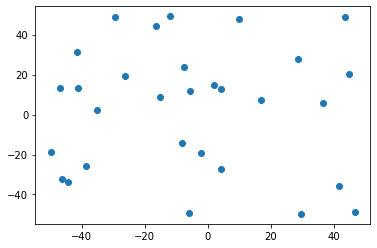

In [29]:
# Number of sensing locations
locations_num = 30

# Size of the map (the map is squared)
map_size = 100.0

# Coordinates of the sensing locations
sensing_locations = (np.random.rand(locations_num, 2) * map_size) - (map_size / 2)

_ = plt.scatter(sensing_locations[:,0], sensing_locations[:,1])

In [30]:
# Number of drones
drones_num = 10

# Length of a single cycle
cycle_length = 1.0

# Definition of the global state

# Coordinates of the drones locations
drones_locations = np.zeros((drones_num, 2), dtype=float)

# Amounts of sensing data to send per drone
sensing_data_amounts = np.zeros(drones_num, dtype=float)

# AoIs (age of information) per sensing location. Denotes the last cycle in which
# any drone performed sensing at a specific sensing location
aois = np.zeros(locations_num, dtype=int)

# Indices of the chosen locations per drone. They are chosen in the decision cycles.
# The initial values are not significant.
chosen_locations = np.zeros(drones_num, dtype=int)


# Returns the AoI of the given location
def get_location_aoi(cycle, location_index):
    return (cycle * cycle_length) - ((aois[location_index] // cycle_length) * cycle_length)

In [32]:
# Number of total cycles for the simulation
cycles_num = 500

# Running simulation (one cycle at a time for every drone)
for cycle in range(1, cycles_num + 1):
    for drone in range(drones_num):
        aoi = get_location_aoi(cycle, chosen_locations[drone])
        if aoi == cycle_length: # Decision cycle
            pass
        elif (drones_locations[drone] != chosen_locations[drone]).all(): # Empty cycle
            pass
        elif sensing_data_amounts[drone] == 0.0: # Sensing cycle
            pass
        else: # Transmission cycle
            pass
